### Imports

In [109]:
import numpy as np
import pandas as pd
import sklearn
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import time

# Part 1: Optimization

In [110]:
# Define logistic equation
logistic = lambda z: 1./ (1 + np.exp(-z))

In [111]:
# Define accuracy function
acc = lambda y,yh: np.mean(y == yh)

In [112]:
# Define cost function
def cost_fn(self, x, y):
    N, D = x.shape                                                       
    z = np.dot(x, self.w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

In [113]:
# Define gradient function
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [114]:
# Function to create batches of size batch_size to be used in mini-batch SGD
def create_batches(self, x, y, batch_size):
  #combine and shuffle data
  data = np.column_stack([x, y])
  np.random.shuffle(data)
  #n_minibatches = data.shape[0] // batch_size
  #we are creating a list of minibatches of size batch_size
  batches = []
  r = data.shape[0] % batch_size
  
  #add first batch here makes it easier for indexing in for loop
  x_mini = data[0:batch_size, :-1]
  y_mini = data[0:batch_size, -1]
  batches.append((x_mini,y_mini))

  for i in range(batch_size, data.shape[0]-r, batch_size):
    x_mini = data[i:i+batch_size, :-1]
    y_mini = data[i:i+batch_size, -1]
    batches.append((x_mini,y_mini))
  #take care of case with leftover data, r != 0
  if data.shape[0] % batch_size !=0:
    x_mini = data[data.shape[0]-r:, :-1]
    y_mini = data[data.shape[0]-r:, -1]
    batches.append((x_mini,y_mini))
  return batches

In [133]:
# Implement Logistic Regregression Class, which also contains functions to perform mini-batch SGD and Momentum.
class LogisticRegression:
    
    def __init__(self, learning_rate=0.1, add_bias=True, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.fit_accuracies = []
        self.momentum_accuracies = []
        self.mini_batch_accuracies = []
        self.mini_momentum_accuracies = []
        self.fit_training_time = 0
        self.mini_training_time = 0
        self.momentum_training_time = 0
        self.mini_momentum_training_time = 0
        
    def fit(self, x, y):
        self.fit_accuracies = []
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0

        start = time.time()
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
            self.fit_accuracies.append(self.get_accuracy(x, y))
        end = time.time()
        self.fit_training_time = end-start
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}, taking {self.fit_training_time} seconds.')
            print(f'the weight found: {self.w}')
        return self

    #function to perform mini-batch SGD, with parameter B = batch size
    def mini_batch_fit(self, x, y, B):
        self.mini_batch_accuracies = []
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D) #change to random values ?
        g = np.inf 
        t = 0
        start = time.time()
        # the code snippet below is for gradient descent
        
        batches = self.create_batches(x, y, B)
        for batch in batches:
          while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            x_mini, y_mini = batch
            g = self.gradient(x_mini, y_mini)
            self.w = self.w - self.learning_rate * g
            self.mini_batch_accuracies.append(self.get_accuracy(x_mini, y_mini)) 
            t += 1
        end = time.time()
        self.mini_training_time = end-start
        if self.verbose:
            print(f'mini-batch terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}, taking {self.mini_training_time} seconds')
            print(f'the weight found: {self.w}')
        return self

    #function to perform gradient descent with momentum with parameter B = beta value
    def momentum_fit(self, x, y, B):
        self.momentum_accuracies = []
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        change = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        start = time.time()
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = B*change+(1-B)*self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            change = g
            self.momentum_accuracies.append(self.get_accuracy(x, y)) 
            t += 1
        end = time.time()
        self.momentum_training_time = end-start
        if self.verbose:
            print(f'gradient descent with momentum terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}, taking {self.momentum_training_time} seconds')
            print(f'the weight found: {self.w}')
        return self

    def mini_momentum_fit(self, x, y, B, batch_size):
        self.mini_momentum_accuracies = []
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D) #change to random values ?
        change = np.zeros(D)
        g = np.inf 
        t = 0
        start = time.time()
        # the code snippet below is for gradient descent
        
        batches = self.create_batches(x, y, batch_size)
        for batch in batches:
            while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
                x_mini, y_mini = batch
                g = B*change+(1-B)*self.gradient(x_mini, y_mini)
                self.w = self.w - self.learning_rate * g 
                change = g
                self.mini_momentum_accuracies.append(self.get_accuracy(x_mini, y_mini))
                t += 1
        end = time.time()
        self.mini_momentum_training_time = end-start
        if self.verbose:
            print(f'mini-batch with momentum terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}, taking {self.mini_momentum_training_time} seconds')
            print(f'the weight found: {self.w}')
        return self
      
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def get_cost(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        return self.cost_fn(x, y)

    def get_accuracy(self, x, target):
        yh = logistic(np.dot(x,self.w))
        return acc(target, yh)

    def get_fit_accuracies(self):
        return self.fit_accuracies
    
    def get_mini_batch_accuracies(self):
        return self.mini_batch_accuracies
    
    def get_momentum_accuracies(self):
        return self.momentum_accuracies

    def get_fit_training_time(self):
        return self.fit_training_time
    def get_mini_training_time(self):
        return self.mini_training_time
    def get_momentum_training_time(self):
        return self.momentum_training_time
    def get_max_iters(self):
        return self.max_iters

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function
LogisticRegression.create_batches = create_batches
LogisticRegression.cost_fn = cost_fn


## Import Diabetes Dataset

In [116]:

diabetes_train_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/diabetes/diabetes_train.csv"
diabetes_test_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/diabetes/diabetes_test.csv"
diabetes_val_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/diabetes/diabetes_val.csv"

diabetes_train = pd.read_csv(diabetes_train_url)
diabetes_train = diabetes_train.to_numpy()

x_train = diabetes_train[:,:-1]
y_train = diabetes_train[:,-1]


diabetes_test = pd.read_csv(diabetes_test_url)
diabetes_test = diabetes_test.to_numpy()

x_test = diabetes_test[:,:-1]
y_test = diabetes_test[:,-1]

diabetes_val = pd.read_csv(diabetes_val_url)
diabetes_val = diabetes_val.to_numpy()

x_val = diabetes_val[:,:-1]
y_val = diabetes_val[:,-1]

## Run Model

### Regular Gradient Descent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


terminated after 1000000 iterations, with norm of the gradient equal to 58.66898195367485, taking 77.98532795906067 seconds.
the weight found: [ 5.34155657e+04  1.32534688e+04 -4.07295289e+03 -1.12791187e+03
  2.58283323e+03  1.47938413e+04  2.40874166e+05  1.63156229e+03
 -2.00686404e+06]
Training accuracy: 0.635


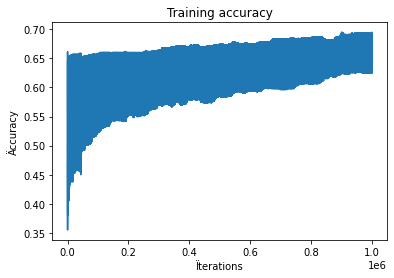

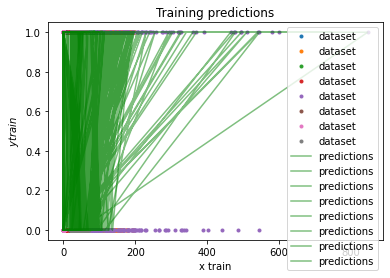

In [117]:
# Run Gradient Descent on diabetes dataset
model = LogisticRegression(learning_rate = 1e2, verbose=True, max_iters=1e6)
yh = model.fit(x_train,y_train).predict(x_train)
print("Training accuracy: "+ str(acc(y_train, yh)))

#plotting number of training iterations vs accuracy
plt.title("Training accuracy")
plt.plot(range(1, int(model.get_max_iters()+1)), model.get_fit_accuracies(), label="accuracy")
plt.xlabel("Ïterations")
plt.ylabel("Äccuracy")
plt.show()

#plotting training predictions vs training data
plt.title("Training predictions")
plt.plot(x_train, y_train, '.', label='dataset')
plt.plot(x_train, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x train')
plt.ylabel(r'$y train$')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


terminated after 1000 iterations, with norm of the gradient equal to 66.52455060962991, taking 0.08665132522583008 seconds.
the weight found: [ 18157166.66666667   5035083.33333329 -10268333.33333336
  -3392249.99999999   3030833.3333334   -2254949.99999994
    477990.16666667   2309583.33333339  -3686166.66666667]
terminated after 1000 iterations, with norm of the gradient equal to 66.52455060962991, taking 0.08310341835021973 seconds.
the weight found: [ 1815716.66666668   503508.33679774 -1026833.33167235  -339225.
   303083.33333333  -225494.99910067    47799.01667459   230958.33399774
  -368616.66664294]
terminated after 1000 iterations, with norm of the gradient equal to 66.69763205286652, taking 0.09135127067565918 seconds.
the weight found: [ 181556.66639049   50471.01164158 -102627.13204223  -33912.50294583
   30430.          -22399.28275588    4781.12807225   23222.64725675
  -36858.98283607]
terminated after 1000 iterations, with norm of the gradient equal to 66.697632052866

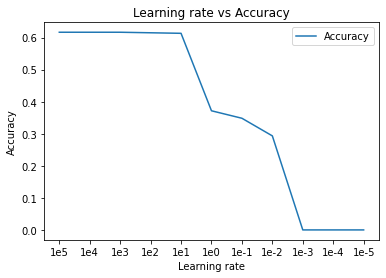

In [118]:
#plotting learning rate vs accuracy for learning rate = 1e-i for i in (1,5)
lr_accuracies = []
for i in range(-5,6):
  lr = 1*(10**(-i))
  model2 = LogisticRegression(learning_rate=lr, verbose=True, max_iters=1000)
  yh = model2.fit(x_train, y_train).predict(x_train)
  lr_accuracies.append(acc(y_train, yh))
plt.title("Learning rate vs Accuracy")
plt.plot(["1e5","1e4","1e3","1e2","1e1","1e0","1e-1", "1e-2", "1e-3", "1e-4", "1e-5"], lr_accuracies, label="Accuracy")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


terminated after 10 iterations, with norm of the gradient equal to 69.67632839338391, taking 0.0015828609466552734 seconds.
the weight found: [  250.66666667  2690.91666667 -1581.83333333  -407.58333333
  2486.           -38.08333333     7.416        321.08333333
   -32.83333333]
terminated after 100 iterations, with norm of the gradient equal to 67.68773402576194, taking 0.0074841976165771484 seconds.
the weight found: [ 2291.5         5204.08333333 -8734.5        -2336.91666667
  2077.5         -970.8           42.5155      1263.91666667
  -369.83333333]
terminated after 1000 iterations, with norm of the gradient equal to 66.69763205286652, taking 0.08328032493591309 seconds.
the weight found: [ 18155.85047398   5033.93573581 -10269.43360195  -3387.51197214
   3040.88054815  -2249.81425293    477.84030534   2336.34192618
  -3686.0773871 ]
terminated after 10000 iterations, with norm of the gradient equal to 67.29620775419907, taking 0.7874236106872559 seconds.
the weight found: [ 551

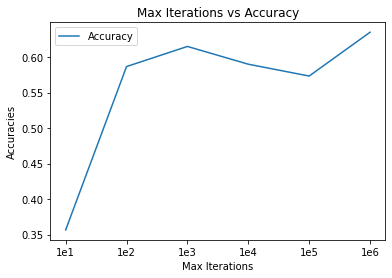

In [119]:
#plotting different values of max_iters vs accuracy
iter_accuracies=[]
for i in range(1, 7):
  iter = 1*(10**i)
  model3 = LogisticRegression(verbose=True, max_iters=iter, learning_rate=1e2)
  yh = model3.fit(x_train,y_train).predict(x_train)
  iter_accuracies.append(acc(y_train, yh))
plt.title("Max Iterations vs Accuracy")
plt.plot(["1e1", "1e2", "1e3", "1e4", "1e5","1e6"], iter_accuracies, label="Accuracy")
plt.xlabel("Max Iterations")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

### Mini-batch SGD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


mini-batch terminated after 1000000 iterations, with norm of the gradient equal to 72.45926333700075, taking 52.870365619659424 seconds
the weight found: [ 4.01808377e+04  1.20679451e+04  1.42939785e+03 -4.90858506e+03
  6.28362647e+01  1.73897166e+04 -1.84261521e+05  1.13033374e+04
 -2.05414002e+06]
Training accuracy: 0.5616666666666666


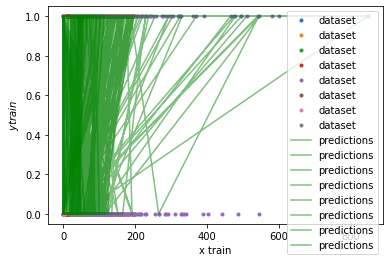

In [120]:
# Run mini-batch SGD on diabetes dataset
#best found model
model = LogisticRegression(verbose=True, learning_rate=1e2, max_iters=1e6)
yh = model.mini_batch_fit(x_train,y_train,64).predict(x_train)
print("Training accuracy: "+ str(acc(y_train, yh)))
plt.plot(x_train, y_train, '.', label='dataset')
plt.plot(x_train, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x train')
plt.ylabel(r'$y train$')
plt.legend()
plt.show()

#note how mini-batch converges much quicker than the other methods used.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


mini-batch terminated after 258 iterations, with norm of the gradient equal to 0.0, taking 0.022367477416992188 seconds
the weight found: [12225.     -2868.75   -1625.      4050.     10393.75   -7430.
  -137.0125 10256.25     -75.    ]
mini-batch terminated after 1000 iterations, with norm of the gradient equal to 21.838614364186576, taking 0.047342538833618164 seconds
the weight found: [  1525.      12112.5     -8728.125   36584.375   -1134.375  -10319.6875
   1094.4375 -40028.125   -1387.5   ]
mini-batch terminated after 1000 iterations, with norm of the gradient equal to 22.011951580058668, taking 0.04848027229309082 seconds
the weight found: [  8183.33333333  15247.91666667   4916.66666667  21787.5
 -14072.91666667 -41833.95833333  -2681.7375     -24020.83333333
  -2316.66666667]
mini-batch terminated after 1000 iterations, with norm of the gradient equal to 33.7356689336289, taking 0.055670738220214844 seconds
the weight found: [  1328.125      -6634.375     -13454.6875      4493.

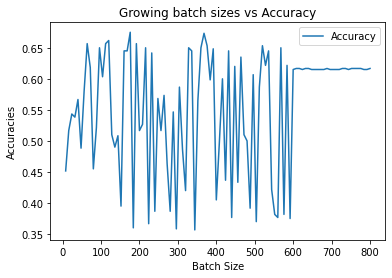

max accuracy found at batch size: 176


In [121]:
#plotting growing batch sizes on accuracy
batch_accuracies = []
xlbl = []
for i in range(8,801,8): 
  xlbl.append(i)  
for i in range(1, 101):
  batch = i*8
  model2 = LogisticRegression(verbose=True, learning_rate=1e2, max_iters=1000)
  yh = model2.mini_batch_fit(x_train,y_train,batch).predict(x_train)
  batch_accuracies.append(acc(y_train, yh))
plt.title("Growing batch sizes vs Accuracy")
plt.plot(range(8, 801, 8), batch_accuracies, label="Accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
print("max accuracy found at batch size: "+str(xlbl[batch_accuracies.index(max(batch_accuracies))]))

### Gradient Descent with Momentum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


gradient descent with momentum terminated after 1000000 iterations, with norm of the gradient equal to 5.021883427476737, taking 82.65952491760254 seconds
the weight found: [   3204.26449547    1200.75051513    -617.90244267    -239.39759009
     257.1274939     1079.76496881   16462.72433016     386.17941809
 -148140.56664453]
Training accuracy: 0.5966666666666667


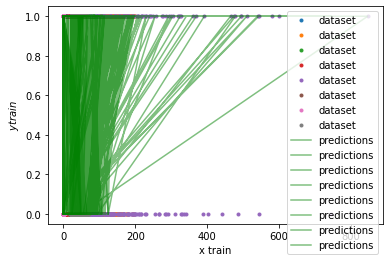

In [123]:
# Run Gradient Descent with momentum on diabetes dataset
#best found model
model = LogisticRegression(verbose=True, learning_rate=1e2, max_iters=1e6)
yh = model.momentum_fit(x_train,y_train,0.9).predict(x_train)
print("Training accuracy: "+ str(acc(y_train, yh)))
plt.plot(x_train, y_train, '.', label='dataset')
plt.plot(x_train, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x train')
plt.ylabel(r'$y train$')
plt.legend()
plt.show()

### Mini-batch gradient descent with momentum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


mini-batch with momentum terminated after 1000000 iterations, with norm of the gradient equal to 1.9193358119740964, taking 56.906800270080566 seconds
the weight found: [ 4.10402495e+03  3.21333913e+02  2.79140997e+01 -1.75982118e+02
  1.16240823e+02  1.98787733e+03  3.11742336e+04  4.36609338e+02
 -1.75151113e+05]
Training accuracy: 0.7333333333333333


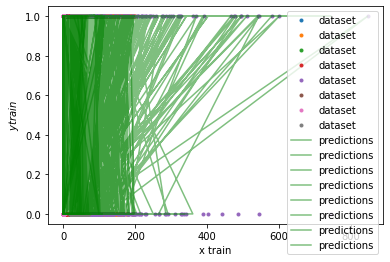

In [134]:
model = LogisticRegression(verbose=True, learning_rate = 1e2, max_iters=1e6)
yh = model.mini_momentum_fit(x_train,y_train,0.9, 64).predict(x_train)
print("Training accuracy: "+ str(acc(y_train, yh)))
plt.plot(x_train, y_train, '.', label='dataset')
plt.plot(x_train, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x train')
plt.ylabel(r'$y train$')
plt.legend()
plt.show()

## Runing models on test data

### Regular gradient descent

In [136]:
model = LogisticRegression(learning_rate = 1e2, verbose=True, max_iters=1e6)
yh = model.fit(x_train,y_train).predict(x_test)
print("Test accuracy: "+ str(acc(y_test, yh)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


terminated after 1000000 iterations, with norm of the gradient equal to 58.66898195367485, taking 77.89013671875 seconds.
the weight found: [ 5.34155657e+04  1.32534688e+04 -4.07295289e+03 -1.12791187e+03
  2.58283323e+03  1.47938413e+04  2.40874166e+05  1.63156229e+03
 -2.00686404e+06]
Test accuracy: 0.5882352941176471


### mini-batch

In [137]:
model = LogisticRegression(verbose=True, learning_rate=1e2, max_iters=1e6)
yh = model.mini_batch_fit(x_train,y_train,64).predict(x_test)
print("Test accuracy: "+ str(acc(y_test, yh)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


mini-batch terminated after 1000000 iterations, with norm of the gradient equal to 50.302746809613105, taking 53.49647116661072 seconds
the weight found: [ 3.67397607e+04  5.30397138e+03 -5.11988494e+03 -6.75632161e+03
  7.23567898e+02  2.79335900e+04  2.74932720e+04  7.34812121e+03
 -2.01478330e+06]
Test accuracy: 0.7058823529411765


### momentum

In [138]:
model = LogisticRegression(verbose=True, learning_rate=1e2, max_iters=1e6)
yh = model.momentum_fit(x_train,y_train,0.9).predict(x_test)
print("Training accuracy: "+ str(acc(y_test, yh)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


gradient descent with momentum terminated after 1000000 iterations, with norm of the gradient equal to 5.021883427476737, taking 82.72342920303345 seconds
the weight found: [   3204.26449547    1200.75051513    -617.90244267    -239.39759009
     257.1274939     1079.76496881   16462.72433016     386.17941809
 -148140.56664453]
Training accuracy: 0.5294117647058824


### mini-batch and momentum

In [139]:
model = LogisticRegression(verbose=True, learning_rate = 1e2, max_iters=1e6)
yh = model.mini_momentum_fit(x_train,y_train,0.9, 64).predict(x_test)
print("Training accuracy: "+ str(acc(y_test, yh)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


mini-batch with momentum terminated after 1000000 iterations, with norm of the gradient equal to 0.564214573791716, taking 56.784019231796265 seconds
the weight found: [ 6.73069542e+03  1.18291129e+03 -4.64217888e+02  3.95826905e+02
 -1.29540537e+02 -5.94338459e+02  6.39161697e+04 -7.44467465e+02
 -1.37456509e+05]
Training accuracy: 0.8235294117647058


# Part 2: Text Classification

## Load Data

In [128]:
def transform_x(x):
  res = []
  for i in range(len(x)):
    res.append(x[i][0])
  return np.array(res)

In [129]:
def get_fake_news_data(url):
  train = pd.read_csv(url)
  train = train.to_numpy()
  train_x = train[:,:-1]
  train_x = transform_x(train_x)
  train_y = train[:,-1]
  return train_x.tolist(), train_y.tolist()

In [130]:
fake_news_train_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/fake_news/fake_news_train.csv"
fake_news_test_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/fake_news/fake_news_test.csv"
fake_news_val_url = "https://raw.githubusercontent.com/dannyboy1044/comp551mp2/main/fake_news/fake_news_val.csv"

fake_news_train_x, fake_news_train_y = get_fake_news_data(fake_news_train_url)
fake_news_test_x, fake_news_test_y = get_fake_news_data(fake_news_test_url)
fake_news_val_x, fake_news_val_y = get_fake_news_data(fake_news_val_url)

print(type(fake_news_train_x))
print(type(fake_news_train_y))

<class 'list'>
<class 'list'>


## Preprocess and build model

In [131]:
text_model = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-4, random_state=42,
...                           max_iter=1000, tol=None)),
... ])

text_model.fit(fake_news_train_x, fake_news_train_y)



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                     

## Running model on test set

In [132]:
predicted = text_model.predict(fake_news_test_x)
a = np.mean(predicted == fake_news_test_y)
print(a)

0.7173333333333334
